In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv('data/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Encoding breeds to discrete integer values for compatibility with loss function

In [3]:
df["breed_coded"] = df.breed.astype('category').cat.codes

# Resizing images to (64, 64, 3), splitting into train/test with ratio 9/1

In [4]:
import os
path_to_imgs = 'data/train'

batch_size = 32
img_height = 64
img_width = 64
dim = (img_width, img_height)


def func(id):
    img = cv2.imread(f'{path_to_imgs}/{id}.jpg', cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_labels, test_labels = train_test_split(df.id, df.breed_coded, 
                                                              test_size=0.1, random_state=42,
                                                             stratify=df.breed_coded)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [6]:
train_images = np.array([func(id) for id in X_train])
test_images = np.array([func(id) for id in X_test])

# Encoding labels into 1/0 vectors

In [7]:
y_binary_train = keras.utils.to_categorical(train_labels)
y_binary_test = keras.utils.to_categorical(test_labels)

# Loading ResNet50 model

In [8]:
base_model = keras.applications.resnet50.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ResNet
    include_top=False)

# Freezing the model

In [9]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
x = base_model.output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
# and a logistic layer -- with 120 classes
NUM_CLASSES = len(df.breed.unique())
predictions = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [13]:
EPOCHS = 16
history = model.fit(
    train_images, y_binary_train, epochs=EPOCHS
)

Train on 9199 samples
Epoch 1/16
9199/9199 [==============================] - 63s 7ms/sample - loss: 4.6188 - accuracy: 0.0594
Epoch 2/16
9199/9199 [==============================] - 63s 7ms/sample - loss: 3.5557 - accuracy: 0.1899
Epoch 3/16
9199/9199 [==============================] - 64s 7ms/sample - loss: 3.0463 - accuracy: 0.2887
Epoch 4/16
9199/9199 [==============================] - 66s 7ms/sample - loss: 2.6705 - accuracy: 0.3705
Epoch 5/16
9199/9199 [==============================] - 72s 8ms/sample - loss: 2.3780 - accuracy: 0.4378
Epoch 6/16
9199/9199 [==============================] - 65s 7ms/sample - loss: 2.1473 - accuracy: 0.4848
Epoch 7/16
9199/9199 [==============================] - 62s 7ms/sample - loss: 1.9770 - accuracy: 0.5223
Epoch 8/16
9199/9199 [==============================] - 64s 7ms/sample - loss: 1.8041 - accuracy: 0.5617
Epoch 9/16
9199/9199 [==============================] - 64s 7ms/sample - loss: 1.6911 - accuracy: 0.5931
Epoch 10/16
9199/9199 [==========

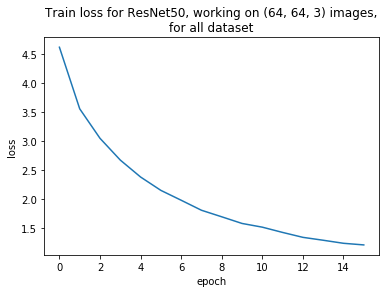

In [15]:
plt.plot(history.history['loss'])
plt.title('Train loss for ResNet50, working on (64, 64, 3) images,\nfor all dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("eda&different_graphs/ResNet50_64x64_forALLLoss.png", dpi=300)
plt.show()

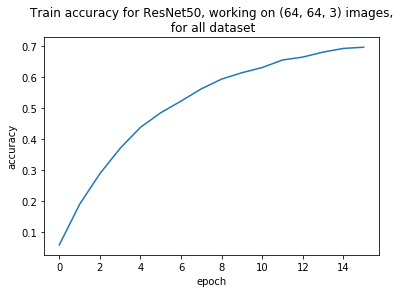

In [16]:
plt.plot(history.history['accuracy'])
plt.title('Train accuracy for ResNet50, working on (64, 64, 3) images,\n for all dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig("eda&different_graphs/ResNet50_64x64_forALLAccuracy.png", dpi=300)
plt.show()

# Evaluation on test images and recording results

In [17]:
results = model.evaluate(test_images, y_binary_test, batch_size=batch_size)
print("test loss, test acc:", results)

1023/1023 [==============================] - 6s 6ms/sample - loss: 11.3835 - accuracy: 0.0899
test loss, test acc: [11.383548402832867, 0.08993158]


In [24]:
res_df = pd.read_csv('results.csv')
res_df.drop(columns=["Unnamed: 0"], inplace=True)
res_df

,TestAccuracy,TestLoss,ModelDescription
0,190.116042,0.104348,"Fine-tuned AlexNet, Normalized, 150 Epochs, No..."
1,5.512277,0.365217,"Fine-tuned ResNet50 on 50 epochs, with input i..."
2,1.071098,0.626087,"Fine-tuned VGG16 on 20 epochs, with input imag..."


In [27]:
losses, accs = res_df.TestLoss.values, res_df.TestAccuracy.values
# res_df.TestLoss, res_df.TestAccuracy = accs, losses
new_df = res_df[['ModelDescription']]
new_df['TestAccuracy'] = losses
new_df['TestLoss'] = accs
new_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ModelDescription,TestAccuracy,TestLoss
0,"Fine-tuned AlexNet, Normalized, 150 Epochs, No...",0.104348,190.116042
1,"Fine-tuned ResNet50 on 50 epochs, with input i...",0.365217,5.512277
2,"Fine-tuned VGG16 on 20 epochs, with input imag...",0.626087,1.071098


In [28]:
new_df = new_df.append(pd.DataFrame({
    "TestAccuracy": [results[1]],
    "TestLoss": [results[0]],
    "ModelDescription": ["ResNet50 on 16 epochs, with input images of shape (64, 64, 3), for ALL data"]
}))
new_df

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,ModelDescription,TestAccuracy,TestLoss
0,"Fine-tuned AlexNet, Normalized, 150 Epochs, No...",0.104348,190.116042
1,"Fine-tuned ResNet50 on 50 epochs, with input i...",0.365217,5.512277
2,"Fine-tuned VGG16 on 20 epochs, with input imag...",0.626087,1.071098
0,"ResNet50 on 16 epochs, with input images of sh...",0.089932,11.383548


In [29]:
new_df.to_csv('results.csv')